# Crypto-Vista by Santiago Reyes

BeautifulSoup & Requests(for webscraping)
Matplotlib & Seaborn(data visualization)
Pandas & Numpy(data manipulation)
Selenium & WebdriverManager (automated web navigation)

In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
import numpy as np
#You will likely need to install the following libraries/dependencies
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys

In [2]:
#The first step is to just get the page data for coingecko.com, which is the site we will be using to extract the data from
mainURL="https://www.coingecko.com"
mainPage=requests.get(mainURL)
htmlSoup=BeautifulSoup(mainPage.text,'lxml')
#Once we have the page data, we select the links for 
allCryptoLinks=htmlSoup.find_all('a', class_="d-lg-none font-bold")
listOfLinks=[link.get('href') for link in allCryptoLinks]
allCryptoNames=htmlSoup.find_all('span',class_="tw-hidden d-lg-inline font-normal text-3xs ml-2")
cryptoNames=[name.text.strip('\n') for name in allCryptoNames]
dataDict={}
#A for loop is used to fill up the dataDict dictionary with the appropriate key value pairs for each cryptcurrency extracted
for i in range(0,len(listOfLinks)):
    newPage=requests.get(mainURL+listOfLinks[i]+'/historical_data/usd#panel')
    time.sleep(2.5)
    #We get the information for the new page and select the data by rows (this is the way its displayed in coingecko)
    newSoup=BeautifulSoup(newPage.text,'lxml')
    rowContent=newSoup.find_all('tr')
    data=[]
    try:
        #The first row of content is just garbage, so we remove it if possible
        rowContent.pop(0)
    except:
        continue
    #Then we simply initialize the variables acording to their position
    for row in rowContent:
        date=row.find('th').text
        priceData=row.find_all('td')
        marketCap=float(priceData[0].text.strip('\n').replace(",","").replace("$",""))
        volume = float(priceData[1].text.strip('\n').replace(",", "").replace("$", ""))
        openPrice = float(priceData[2].text.strip('\n').replace(",", "").replace("$", ""))
        try:
            closePrice = float(priceData[3].text.strip('\n').replace(",", "").replace("$", ""))
        except:
            closePrice=None
        #The newdata is added to the data array
        data.append([date,marketCap,volume ,openPrice,closePrice])
    #Here is where the actual key value pairs for the dictionaries are created
    dataDict[cryptoNames[i]]=data
print(dataDict)

{'BTC': [['2021-07-29', 751371299911.0, 41369107423.0, 40031.0, None], ['2021-07-28', 732311951673.0, 36401287454.0, 39077.0, 40031.0], ['2021-07-27', 701921012035.0, 53550491998.0, 37282.0, 39077.0], ['2021-07-26', 664681184169.0, 20929083221.0, 35456.0, 37282.0], ['2021-07-25', 642012590041.0, 22120323672.0, 34214.0, 35456.0], ['2021-07-24', 627747173675.0, 22937379735.0, 33456.0, 34214.0], ['2021-07-23', 607621607805.0, 19741588059.0, 32409.0, 33456.0], ['2021-07-22', 605357009417.0, 29070652060.0, 32384.0, 32409.0], ['2021-07-21', 561743228117.0, 23000299062.0, 29972.0, 32384.0], ['2021-07-20', 580252472383.0, 20095540828.0, 30928.0, 29972.0], ['2021-07-19', 597872278369.0, 17742105808.0, 31919.0, 30928.0], ['2021-07-18', 592581931071.0, 17715455995.0, 31589.0, 31919.0], ['2021-07-17', 588495008676.0, 22671859963.0, 31400.0, 31589.0], ['2021-07-16', 595342431374.0, 21557729227.0, 31726.0, 31400.0], ['2021-07-15', 616691143980.0, 21779069066.0, 32879.0, 31726.0], ['2021-07-14', 6130

We iterate over the dictionary that we just created in order to obtain the total daily marketCaps for the top 100 cryptocurrencies. Subsequently, we display said data in the form of a plot and a bar graph; this will facilitate our interpretation of the crypto markets behaviour over the last month.

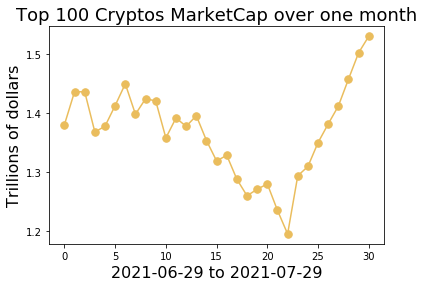

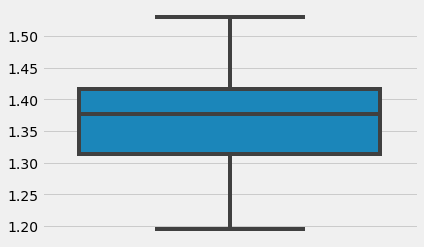

In [3]:
#This array is for the TOTAL MARKET CAP OF THE ENTIRE TOP 100 CRYPTO MARKET 
totalCaps=[]
#The colNames array will be used to create pandas DataFrames (its used for the header)
colNames=['Date','Market Cap','Volume','Open Price','Close Price']
#We also create an array of pandas DataFrames
listedDataTables=[]
#We iterate through the dataDict dictionary
#Transform each key value pair into a DataFrame and append it to the listedDataTables array
for coin in dataDict:
    keyVals=dataDict[coin]
    coinData=pd.DataFrame(data=keyVals, columns=colNames)
    listedDataTables.append(coinData)
    minDate=keyVals[0][0]
    maxDate=keyVals[-1][0]
    for i in range(len(keyVals)):
        currPrice=keyVals[i][1]
        #We add the daily marketcaps to the totalCaps array so we can plot the data later
        try:
            totalCaps[i]+=float(currPrice)/1000000000000
        except ValueError:
            continue
        except:
            totalCaps.append(float(currPrice)/1000000000000)
#Since the data is recorded in order of appearance in the web page (newset to latest), we need to reverse it
totalCaps.reverse()
#Then we simply create the plot

plt.figure()
plt.plot(totalCaps, "#EABD5D", marker='.', markersize=15)
plt.xlabel(f'{maxDate} to {minDate}',fontsize=16)
plt.ylabel("Trillions of dollars",fontsize=16)
plt.title("Top 100 Cryptos MarketCap over one month",fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

#Create a seaborn boxplot for our data to visualize normal distributions

sns.boxplot(y=totalCaps)

The following function is not really meant to be called the user of the program. It is called inside the visByTick function whenever the ticker being passed as an argument is not in the data dictionary (dataDict). This function retrieves the data for the crypto whose ticker is passed as an argument and returns the full name of the crypto currency (for display purposes) and the data that was retrieved.

In [4]:
def getDataByTick(ticker):
    #We declare the driver variable and
    driver=webdriver.Chrome(ChromeDriverManager().install())
    driver.get(mainURL)
    #We use the find_element_by_xpath function to automate the navigation of coingecko.com
    searchBox=driver.find_element_by_xpath('/html/body/div[2]/div[3]/div[2]/div[1]/div/div/input')
    searchBox.send_keys(ticker)
    time.sleep(3)
    searchBox.send_keys(Keys.RETURN)
    currentURL=driver.current_url
    print(currentURL)
    #Then we use requests and BeautifulSoup to get the html data for the page we are in
    newCryptoPage=requests.get(currentURL+'/historical_data/usd#panel')
    time.sleep(2)
    newCryptoSoup=BeautifulSoup(newCryptoPage.text,'lxml')
    #We collect all of the rows
    rowContent=newCryptoSoup.find_all('tr')
    #Array creation so we can append data to it later
    data=[]
    #For some reason in the spanish page, the periods and commas are reversed (a decimal is writen like 0,6 instead of 0.6)
    #This basically breaks the whole program, so we will check if the periods and commas are reversed with a boolean variable
    dotCommasReversed=False
    #The first row of content is just garbage, so we remove it if possible
    try:
        rowContent.pop(0)
    except:
        pass
    #Then we process all of the row data and conver the numbers into floats so we can plot them accurately later
    for row in rowContent:
        date=row.find('th').text
        priceData=row.find_all('td')
        if "." in priceData[0].text:
            dotCommasReversed=True
        #This is where we do different processes if we are on the spanish or english site
        if not dotCommasReversed:
            marketCap=float(priceData[0].text.strip('\n').replace(",","").replace("$",""))
            volume = float(priceData[1].text.strip('\n').replace(",", "").replace("$", ""))
            openPrice = float(priceData[2].text.strip('\n').replace(",", "").replace("$", ""))
            try:
                closePrice = float(priceData[3].text.strip('\n').replace(",", "").replace("$", ""))
            except:
                    closePrice=None
        else:
            marketCap=float(priceData[0].text.strip('\n').replace(".","").replace("$","").replace(",", "."))
            volume = float(priceData[1].text.strip('\n').replace(".", "").replace("$", "").replace(",", "."))
            openPrice = float(priceData[2].text.strip('\n').replace(".", "").replace("$", "").replace(",", "."))
            try:
                closePrice = float(priceData[3].text.strip('\n').replace(".", "").replace("$", "").replace(",", "."))
            except:
                    closePrice=None
        #We append the prossesed data to our data array
        data.append([date,marketCap,volume ,openPrice,closePrice])
    #We grab the cryptos full name from the url and return it alongside the full data
    crypName=currentURL.split('/')[5].upper()
    return crypName,data

The following function, named visByTick (short for visualize by ticker), is intended to allow the visualization of a cryptocurrencies behaviour. Only one argument is really necessary: the ticker; which is how the function determines what to plot. If the crypto being passed as an argument is not in the dictionary containing all of the data (dataDict), the function will use selenium and beautiful soup to search for and retrieve that data and add it to the dictionary. The other arguments that can be passed will simply determine what is returned (in the case of infoTable) or what is displayed (in the case of all the other parameters).

In [5]:
def visByTick(ticker,marketCapPlots=True,volumePlots=False,pricePlots=False,infoTable=True,boxPlots=False):
    #This text will be displayed upon calling help(visByTick), which can be useful for the user
    """
    This function allows you to visualize the date of a single Crypto 
    Its important to remember that by default the data used is from the last month alone
    
    Necessary Arguments:
    ticker (string): represents the ticker of the CryptoCurrency that will be visualized. Ex: 'ada' for cardano
    
    Optional Arguments:
    marketCapPlots (boolean, default=True): determines whether or not the graphs for market caps are shown
    volumePlots (boolean, default=False): determines whether or not the graphs for the transaction volumes are shown
    pricePlots (boolean, default=False): determines whether or not the graphs for the daily opening prices
    infoTable (boolean, default=True): determines if the complete info table for that crypto is returned or not
    boxPlots (boolean, default=False): indicates if boxplots will be shown alongside the line graph in the plotting functions
    """
    ticker=ticker.upper()
    #We check if the crypto being called for is already in our dataDict dictionary
    if ticker in dataDict:
        #We gram the full cryptos name
        cryptoIndex=cryptoNames.index(ticker)
        currentCryptoName=listOfLinks[cryptoIndex].split('/')[3].upper()
        #We grab the ticker data as well as the 
        print(f'------------------------{currentCryptoName}------------------------')
        tickerData=listedDataTables[cryptoIndex]
        keyValues=dataDict[ticker]
        #We get the starting and end dates of the dataset for display purposes
        lastDay=keyValues[0][0]
        firstDay=keyValues[-1][0]
    #If the crypto is not in our dataDict dictionary, we need to get that data and add it to the dictionary
    else:
        print(f"Cryptocurrency not in top 100, give me a second to look for {ticker}'s data'")
        #We use the getDataByTick() function to get the cryptos full name as well as its data
        currentCryptoName,returnData=getDataByTick(ticker)
        dataDict[ticker]=returnData
        #We create the pandas DataFrame
        tickerData=pd.DataFrame(data=returnData,columns=colNames)
        #We add the found data to listOfLinks, cryptoNames and listedDataTables
        cryptoNames.append(ticker)
        newLink=f'/en/coins/{currentCryptoName.lower()}'
        listOfLinks.append(newLink)
        listedDataTables.append(tickerData)
        keyValues=returnData
        lastDay=keyValues[0][0]
        firstDay=keyValues[-1][0]
        print(f'------------------------{currentCryptoName}------------------------')
        
    #The following if statements are executed depending on the arguments passed by the user
    #If the user wants to display the market cap plots
    if marketCapPlots:
        dailyMarketCaps=[float(keyValues[i][1])/1000000000 for i in range(len(keyValues))]
        dailyMarketCaps.reverse()
        print(f"Here is the data for {currentCryptoName}'s market cap")
        averageMarketCap=round(sum(dailyMarketCaps)/len(dailyMarketCaps),2)
        print(f'The average MARKET CAP of {currentCryptoName} over the past month is {averageMarketCap} billions of dollars')
        plt.figure
        plt.plot(dailyMarketCaps,"#EABD5D", marker='.', markersize=15)
        plt.xlabel(f'{firstDay} to {lastDay}',fontsize=16)
        plt.ylabel("Billions of Dollars",fontsize=16)
        plt.title(f'MarketCap of {currentCryptoName}',fontsize=18)
        plt.style.use('fivethirtyeight')
        plt.show()
        #If the user also wants the boxplots instead of just getting the regular plots
        if boxPlots:
            sns.boxplot(y=dailyMarketCaps).set_title(f'MarketCap of {currentCryptoName}')
            plt.ylabel('Billions of Dollars')
            plt.show()
    
    #If the user wants to display the volume plots
    if volumePlots:
        print(f"Here is the data for {currentCryptoName}'s volume")
        dailyVolume=[float(keyValues[i][2])/1000000 for i in range(len(keyValues))]
        dailyVolume.reverse()
        averageVolume=round(sum(dailyVolume)/len(dailyVolume),2)
        print(f'The average VOLUME of {currentCryptoName} over the past month is {averageVolume} millions of dollars')
        plt.figure()
        plt.plot(dailyVolume,"#9F5CEB", marker='.', markersize=15)
        plt.xlabel(f'{firstDay} to {lastDay}',fontsize=16)
        plt.ylabel("Millions of Dollars",fontsize=16)
        plt.title(f'Volume of {currentCryptoName}',fontsize=18)
        plt.style.use('fivethirtyeight')
        plt.show()
        #If the user also wants the boxplots instead of just getting the regular plots
        if boxPlots:
            sns.boxplot(y=dailyVolume).set_title(f'Volume of {currentCryptoName}')
            plt.ylabel('Millions of Dollars')
            plt.show()
            
    #If the user wants to display the price plots
    if pricePlots:
        print(f"Here is the data for {currentCryptoName}'s price opens")
        dailyCloses=[float(keyValues[i][3]) for i in range(len(keyValues))]
        dailyCloses.reverse()
        averageOpen=round(sum(dailyCloses)/len(dailyCloses),2)
        print(f'The average OPENING PRICE of {currentCryptoName} over the past month is {averageOpen} dollars')
        plt.figure()
        plt.plot(dailyCloses,"#CB5B5A", marker='.', markersize=15)
        plt.xlabel(f'{firstDay} to {lastDay}',fontsize=16)
        plt.ylabel("Dollars",fontsize=16)
        plt.title(f'Price of {currentCryptoName}',fontsize=18)
        plt.style.use('fivethirtyeight')
        plt.show()
        #If the user also wants the boxplots instead of just getting the regular plots
        if boxPlots:
            sns.boxplot(y=dailyCloses).set_title(f'Price of {currentCryptoName}')
            plt.ylabel('Dollars')
            plt.show()    
    
    #If the user wants the function to return the pandas DataFrame or not
    if infoTable:
        return tickerData

The following function, named massExtract is utilized for mass extractions of data; it pull up the entire history for the desired cryptocurrency and subsequently graphs it depending on the boolean arguments passed in. Also, a pandas DataFrame is returned from this function unless specified otherwise in the arguments. Fianlly, since this function is called when the user wants all of the data from a certain cryptocurrency, it is possible that they may want to be able to export that information. To save the data to a file, simply set the value of writeToCsv or writeToXlsx according to the users format preference.

In [6]:
def massExtract(ticker, marketCapPlots=False,volumePlots=False,pricePlots=False,infoTable=True,writeToCsv=False,writeToXlsx=False):
    #This text will be displayed upon calling help(visByTick), which can be useful for the user
    """
    Returns a pandas DataFrame containing the entire daily data for a cryptocurrency based on the provided ticker
    
    This function allows for the extraction of ALL AVAILABLE DATA from a single cryptocurrency using its ticker
    It also allows you to plot the data according to your specifications, but by default it will only return the DataFrame
    
    Necessary Arguments:
    ticker (string): represents the ticker of the CryptoCurrency that will be visualized. Ex: 'ada' for cardano
    
    Optional Arguments for data visualization:
    Keep in mind that all of these can be used and will not interfere with each other
    
    marketCapPlots (boolean, default=False): determines whether or not the graphs for market caps are shown
    volumePlots (boolean, default=False): determines whether or not the graphs for the transaction volumes are shown
    pricePlots (boolean, default=False): determines whether or not the graphs for the daily opening prices
    infoTable (boolean, default=True): determines if the complete info table for that crypto is returned or not
    
    Optional Arguments for writing/saving data:
    Keep in mind that all of these can be used and will not interfere with each other
    The file will be saved by the name cryptoTicker_data_currentDate.xlsx or .csv Ex: "btc_data_2021-07-28.csv"
    
    writeToCsv (boolean, default=False): determines if the data that was retrieved will be saved to a csv file or not
    writeToXlsx (boolean, default=False): determines if the data that was retrieved will be saved to a xlsx file or not
    """
    #First we initialize the driver variable with the coingecko url
    driver=webdriver.Chrome(ChromeDriverManager().install())
    driver.get(mainURL)
    #We use driver to automate the web navigation requiered to find all the historical data available 
    searchBox=driver.find_element_by_xpath('/html/body/div[2]/div[3]/div[2]/div[1]/div/div/input')
    searchBox.send_keys(ticker)
    time.sleep(3)
    searchBox.send_keys(Keys.RETURN)
    currentURL=driver.current_url
    driver.get(currentURL+'/historical_data/usd#panel')
    dateBox=driver.find_element_by_xpath('/html/body/div[4]/div[7]/div/div[2]/div/div/div[2]/div[2]/input[1]')
    dateBox.click()
    year=driver.find_element_by_xpath('/html/body/div[11]/div[1]/div/div/div/input')
    year.clear()
    #The earliest data present in the site is for bitcoin in 2013, but we do 2010 just to be sure we get all of it
    year.send_keys('2010')
    dateToClick=driver.find_element_by_xpath('/html/body/div[11]/div[2]/div/div[2]/div/span[1]')
    dateToClick.click()
    
    #Once we actually have made it to the page cointaining all of the data, we use requests and BeautifulSoup to extract it
    newCryptoPage=requests.get(driver.current_url)
    newCryptoSoup=BeautifulSoup(newCryptoPage.text,'lxml')
    currentURL=driver.current_url
    
    #We find all of the information rows we need to process
    rowContent=newCryptoSoup.find_all('tr')
    completeData=[]
    #For some reason in the spanish page, the periods and commas are reversed (a decimal is writen like 0,6 instead of 0.6)
    #This basically breaks the whole program, so we will check if the periods and commas are reversed with a boolean variable
    dotCommasReversed=False
    #The first row of content is just garbage, so we remove it if possible
    try:
        rowContent.pop(0)
    except:
        pass
    for row in rowContent:
        date=row.find('th').text
        priceData=row.find_all('td')
        if "." in priceData[0].text:
            dotCommasReversed=True
        #Here is where we do different processes if the page is loaded in english or spanish
        if not dotCommasReversed:
            marketCap=float(priceData[0].text.strip('\n').replace(",","").replace("$","").replace('N/A','0.0'))
            volume = float(priceData[1].text.strip('\n').replace(",", "").replace("$", ""))
            openPrice = float(priceData[2].text.strip('\n').replace(",", "").replace("$", ""))
            try:
                closePrice = float(priceData[3].text.strip('\n').replace(",", "").replace("$", ""))
            except:
                    closePrice=None
        else:
            marketCap=float(priceData[0].text.strip('\n').replace(".","").replace("$","").replace('N/A','0.0').replace(",", "."))
            volume = float(priceData[1].text.strip('\n').replace(".", "").replace("$", "").replace(",", "."))
            openPrice = float(priceData[2].text.strip('\n').replace(".", "").replace("$", "").replace(",", "."))
            try:
                closePrice = float(priceData[3].text.strip('\n').replace(".", "").replace("$", "").replace(",", "."))
            except:
                    closePrice=None
        #Once the data is processed, we append it to the completeData array
        completeData.append([date,marketCap,volume ,openPrice,closePrice])
    
    #We grab the start and end date of the data as well as the cryptocurrencies full name (for display purposes)
    maxDate=completeData[0][0]
    minDate=completeData[-1][0]
    crypName=currentURL.split('/')[5].upper()
    
    #If the user wants to display the maket cap plots
    if marketCapPlots:
        marketCapVals=[dataPoint[1]/1000000000 for dataPoint in completeData]
        marketCapVals.reverse()
        plt.figure()
        plt.plot(marketCapVals, "#EABD5D")
        plt.xlabel(f'{minDate} to {maxDate}',fontsize=16)
        plt.ylabel("Billions of Dollars",fontsize=16)
        plt.title(f'MarketCap of {crypName}',fontsize=18)
        plt.style.use('fivethirtyeight')
        plt.show()

        
    #If the user wants to display the volume plots
    if volumePlots:
        volumeVals=[dataPoint[2]/1000000 for dataPoint in completeData]
        volumeVals.reverse()
        plt.figure()
        plt.plot(volumeVals,"#9F5CEB")
        plt.xlabel(f'{minDate} to {maxDate}',fontsize=16)
        plt.ylabel("Millions of Dollars",fontsize=16)
        plt.title(f'Volume of {crypName}',fontsize=18)
        plt.style.use('fivethirtyeight')
        plt.show()

    
    #If the user wants to display the price plots
    if pricePlots:
        openPriceVals=[dataPoint[3] for dataPoint in completeData]
        openPriceVals.reverse()
        plt.figure()
        plt.plot(openPriceVals,"#CB5B5A")
        plt.xlabel(f'{minDate} to {maxDate}',fontsize=16)
        plt.ylabel("Dollars",fontsize=16)
        plt.title(f'Price of {crypName}',fontsize=18)
        plt.style.use('fivethirtyeight')
        plt.show()

    #We convert the full set of data from an array to a pandas data set
    finalDataFrame=pd.DataFrame(data=completeData,columns=colNames)
    
    #If the user wants to write the data to an exel file(.xlsx)
    if writeToXlsx:
        finalDataFrame.to_excel(excel_writer=f'data/{ticker}_data_{maxDate}.xlsx', index=False)
    
    #If the user wants to write the data to a csv file (.csv)
    if writeToCsv:
        finalDataFrame.to_csv(path_or_buf=f'data/{ticker}_data_{maxDate}.csv', index=False)

    #If the user wants the DataFrame to be returned by the function, which it will do by default
    if infoTable:
        return finalDataFrame


In [96]:
import random
print(random.randint(100,1000))

179


------------------------BITCOIN------------------------
Here is the data for BITCOIN's market cap
The average MARKET CAP of BITCOIN over the past month is 635.65 billions of dollars


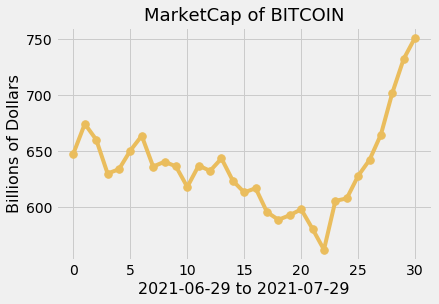

,Date,Market Cap,Volume,Open Price,Close Price
0,2021-07-29,7.513713e+11,4.136911e+10,40031.0,NaN
1,2021-07-28,7.323120e+11,3.640129e+10,39077.0,40031.0
2,2021-07-27,7.019210e+11,5.355049e+10,37282.0,39077.0
3,2021-07-26,6.646812e+11,2.092908e+10,35456.0,37282.0
4,2021-07-25,6.420126e+11,2.212032e+10,34214.0,35456.0
5,2021-07-24,6.277472e+11,2.293738e+10,33456.0,34214.0
6,2021-07-23,6.076216e+11,1.974159e+10,32409.0,33456.0
7,2021-07-22,6.053570e+11,2.907065e+10,32384.0,32409.0
8,2021-07-21,5.617432e+11,2.300030e+10,29972.0,32384.0
9,2021-07-20,5.802525e+11,2.009554e+10,30928.0,29972.0


In [94]:
bitcoinTable=visByTick('btc')
bitcoinTable

------------------------DOGECOIN------------------------
Here is the data for DOGECOIN's market cap
The average MARKET CAP of DOGECOIN over the past month is 27.64 billions of dollars


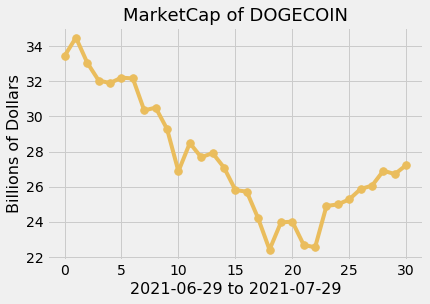

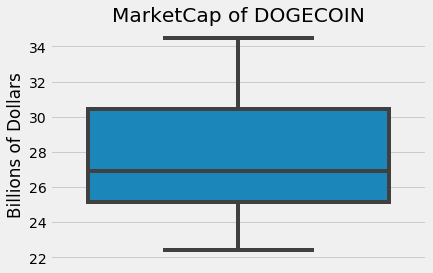

Here is the data for DOGECOIN's volume
The average VOLUME of DOGECOIN over the past month is 1929.86 millions of dollars


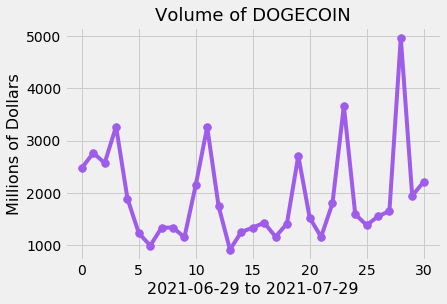

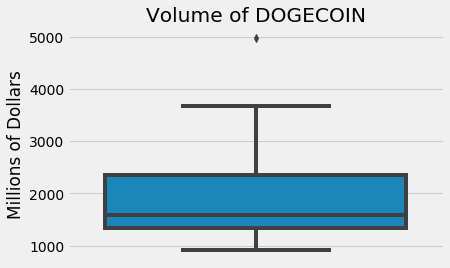

Here is the data for DOGECOIN's price opens
The average OPENING PRICE of DOGECOIN over the past month is 0.21 dollars


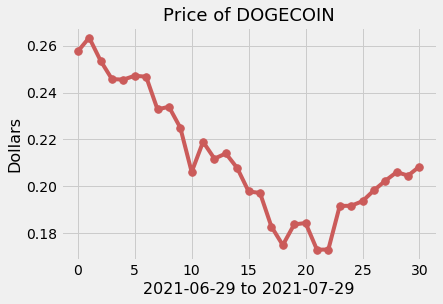

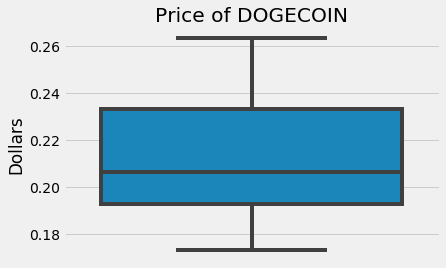

,Date,Market Cap,Volume,Open Price,Close Price
0,2021-07-29,2.722571e+10,2.209278e+09,0.208425,NaN
1,2021-07-28,2.671498e+10,1.943999e+09,0.204539,0.208425
2,2021-07-27,2.690890e+10,4.968959e+09,0.206030,0.204539
3,2021-07-26,2.605852e+10,1.651935e+09,0.202326,0.206030
4,2021-07-25,2.586942e+10,1.550001e+09,0.198246,0.202326
5,2021-07-24,2.527766e+10,1.382746e+09,0.193613,0.198246
6,2021-07-23,2.498932e+10,1.590345e+09,0.191647,0.193613
7,2021-07-22,2.490230e+10,3.663618e+09,0.191588,0.191647
8,2021-07-21,2.254833e+10,1.798516e+09,0.172966,0.191588
9,2021-07-20,2.268403e+10,1.157742e+09,0.172888,0.172966


In [95]:
visByTick('doge',volumePlots=True,boxPlots=True,pricePlots=True)



====== WebDriver manager ======
Current google-chrome version is 92.0.4515
Get LATEST driver version for 92.0.4515


Cryptocurrency not in top 100, give me a second to look for XPRT's data'


Driver [C:\Users\user\.wdm\drivers\chromedriver\win32\92.0.4515.43\chromedriver.exe] found in cache
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\anaconda3\lib\site-packages\selenium\webdriver\remote\webdriver.py:451: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


https://www.coingecko.com/es/monedas/persistence
------------------------PERSISTENCE------------------------
Here is the data for PERSISTENCE's market cap
The average MARKET CAP of PERSISTENCE over the past month is 0.23 billions of dollars


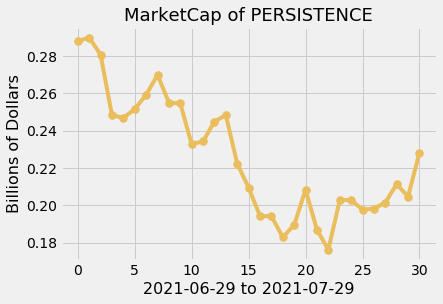

Here is the data for PERSISTENCE's volume
The average VOLUME of PERSISTENCE over the past month is 1.23 millions of dollars


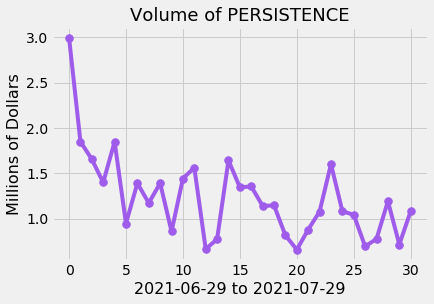

,Date,Market Cap,Volume,Open Price,Close Price
0,2021-07-29,228187615.0,1082160.0,6.41,NaN
1,2021-07-28,204634559.0,714401.0,6.31,6.41
2,2021-07-27,211303635.0,1192013.0,6.48,6.31
3,2021-07-26,201453838.0,776482.0,6.29,6.48
4,2021-07-25,198234556.0,693245.0,6.13,6.29
5,2021-07-24,197665121.0,1041894.0,6.13,6.13
6,2021-07-23,202826440.0,1081017.0,6.28,6.13
7,2021-07-22,202738817.0,1600549.0,6.35,6.28
8,2021-07-21,176224795.0,1077846.0,5.52,6.35
9,2021-07-20,186907795.0,878976.0,5.84,5.52


In [97]:
visByTick('XPRT', volumePlots=True)

In [ ]:
massExtract('XPRT',marketCapPlots=True, volumePlots=True,pricePlots=True,writeToCsv=True)



====== WebDriver manager ======
Current google-chrome version is 92.0.4515
Get LATEST driver version for 92.0.4515
Driver [C:\Users\user\.wdm\drivers\chromedriver\win32\92.0.4515.43\chromedriver.exe] found in cache
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
C:\Users\user\anaconda3\lib\site-packages\selenium\webdriver\remote\webdriver.py:451: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")
